In [5]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

import torch
import random

from sae.sparse_autoencoder import load_saved_sae
from sae.metrics import model_store_from_sae
from unlearning.metrics import convert_wmdp_data_to_prompt, convert_list_of_dicts_to_dict_of_lists
from unlearning.tool import UnlearningConfig, SAEUnlearningTool, MCQ_ActivationStoreAnalysis, ActivationStoreAnalysis
from unlearning.metrics import modify_and_calculate_metrics, calculate_metrics_list, create_df_from_metrics
from unlearning.feature_attribution import calculate_cache

from huggingface_hub import hf_hub_download
from datasets import load_dataset
import numpy as np
import pandas as pd
import itertools
from transformer_lens import utils

from jaxtyping import Float
from torch import Tensor

import einops

from pathlib import Path

import plotly.express as px
from unlearning.var import REPO_ID, SAE_MAPPING
import pickle

from unlearning.metrics import all_permutations

from unlearning.metrics import calculate_metrics_side_effects
from unlearning.feature_attribution import find_topk_features_given_prompt, test_topk_features
import matplotlib.pyplot as plt

from unlearning.var import gemma_2b_it_rmu_model_names



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import matplotlib as mpl
from cycler import cycler

mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.markersize'] = 1.4

mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['xtick.major.width'] = 0.4
mpl.rcParams['xtick.minor.width'] = 0.4
mpl.rcParams['xtick.major.size'] = 4
mpl.rcParams['xtick.minor.size'] = 2

mpl.rcParams['ytick.right'] = True
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['ytick.major.width'] = 0.4
mpl.rcParams['ytick.minor.width'] = 0.4
mpl.rcParams['ytick.major.size'] = 4
mpl.rcParams['ytick.minor.size'] = 2

mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

mpl.rcParams['axes.titlesize'] = 10
mpl.rcParams['axes.labelsize'] = 10


mpl.rcParams['legend.frameon'] = False
mpl.rcParams['legend.fontsize'] = 9

mpl.rcParams['figure.figsize'] = 6, 4

mpl.rcParams['axes.prop_cycle'] = cycler("color", ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Plotting
fig_dir = "../figs"

def create_lineplot_histogram(distribution, bins=20):
    vals, bin_edges = np.histogram(distribution, bins=bins)

    xvals = np.repeat(bin_edges, 2)
    yvals = np.repeat(vals, 2)
    yvals = np.concatenate(([0], yvals, [0]))

    return xvals, yvals

In [7]:
df

,loss_added,wmdp-bio,high_school_us_history,college_computer_science,high_school_geography,human_aging,college_biology,wmdp-bio_prob,high_school_us_history_prob,college_computer_science_prob,high_school_geography_prob,human_aging_prob,college_biology_prob
0,-0.000044,0.988372,1.0,1.0,1.0,1.0,1.000,0.989746,0.995605,0.999023,0.998047,0.986328,0.996094
1,-0.000152,0.976744,1.0,1.0,1.0,1.0,1.000,0.989746,0.995605,0.999023,0.998047,0.986328,0.996094
2,-0.000646,0.976744,1.0,1.0,1.0,1.0,1.000,0.989258,0.995605,0.999023,0.998047,0.986328,0.996094
3,-0.000221,0.953488,1.0,1.0,1.0,1.0,1.000,0.989746,0.995605,0.999023,0.998047,0.986328,0.995605
4,-0.000037,0.953488,1.0,1.0,1.0,1.0,1.000,0.989746,0.995605,0.999023,0.998047,0.986328,0.995605
5,0.000515,0.953488,1.0,1.0,1.0,1.0,1.000,0.989746,0.995605,0.999023,0.998047,0.986328,0.995605
6,0.000532,0.953488,1.0,1.0,1.0,1.0,1.000,0.989746,0.995605,0.999023,0.998047,0.986328,0.995605
7,0.000528,0.965116,1.0,1.0,1.0,1.0,1.000,0.988770,0.995605,0.999023,0.998047,0.986328,0.995605
8,0.000528,0.953488,1.0,1.0,1.0,1.0,0.875,0.987305,0.995605,0.999023,0.998047,0.993164,0.975586
9,0.000524,0.930233,1.0,1.0,1.0,1.0,0.875,0.987305,0.995605,0.999023,0.998047,0.993164,0.975586


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


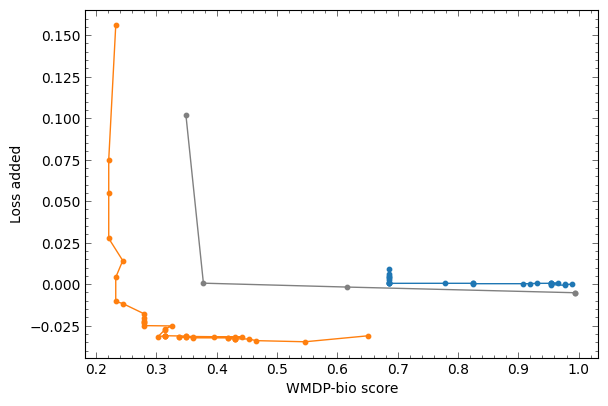

In [14]:
fig, ax = plt.subplots(figsize=(6, 4))


with open("../eoin_notebooks/df_metrics_0_side_effect.pkl", "rb") as f:
    df = pickle.load(f)
    
ax.plot(df['wmdp-bio'].values, df['loss_added'].values)
ax.scatter(df['wmdp-bio'].values, df['loss_added'].values, marker='o', s=10)

with open("../eoin_notebooks/df_metrics_5_side_effect.pkl", "rb") as f:
    df = pickle.load(f)
    
ax.plot(df['wmdp-bio'].values, df['loss_added'].values)
ax.scatter(df['wmdp-bio'].values, df['loss_added'].values, marker='o', s=10)



# Plot RMU results

rmu_wmdp_bio_results = []
rmu_side_effect_results = []
rmu_loss_added_results = []

for model_name in gemma_2b_it_rmu_model_names:
    model_name = model_name.split('/')[-1]
    with open(f'../data/unlearn_results/gemma-2b-it/rmu/correct/{model_name}.pkl', 'rb') as f:
        results = pickle.load(f)
    rmu_wmdp_bio_results.append(results['wmdp-bio']['mean_correct'])
    rmu_side_effect_results.append(results['high_school_us_history']['mean_correct'])
    rmu_loss_added_results.append(results['loss_added'])
    
ax.plot(rmu_wmdp_bio_results, rmu_loss_added_results, color='grey')
ax.scatter(rmu_wmdp_bio_results, rmu_loss_added_results, s=10, marker='o', color='grey')


ax.legend()


# yticks = [-6, -5, -4, -3, -2, -1, 0]
# yticklabels = [r"10$^{-6}$", r"10$^{-5}$", r"10$^{-4}$", r"10$^{-3}$", 0.01, 0.1, 1]
# yminor_ticks = np.log10(np.concatenate((np.arange(1e-6, 1e-5, 1e-6),
#                                         np.arange(1e-5, 1e-4, 1e-5),
#                                         np.arange(1e-4, 1e-3, 1e-4),
#                                         np.arange(1e-3, 1e-2, 1e-3),
#                                         np.arange(1e-2, 1e-1, 1e-2),
#                                         np.arange(1e-1, 1, 1e-1))))

# ax.set_yticks(yticks)
# ax.set_yticklabels(yticklabels)
# ax.set_yticks(yminor_ticks, minor=True)


# xticks = [1, 2, 5, 10, 20, 50, 100]
# xticklabels = xticks
# xminor_ticks = np.log10(np.concatenate((np.arange(1, 10, 1), np.arange(10, 100, 10), np.arange(100, 1000, 100), np.arange(1000, 1e4, 1e3))))

# ax.set_xticks(np.log10(xticks))
# ax.set_xticklabels(xticklabels)
# ax.set_xticks(xminor_ticks, minor=True)
                       

# ax.set_xlim(0, np.log10(250))
# ax.set_ylim(-6, )

ax.set_xlabel("WMDP-bio score")
ax.set_ylabel("Loss added")


fig.subplots_adjust(right=0.98, top=0.98)
fig.savefig(fig_dir + "/multiple_features/prob_vs_multiplier2.png", dpi=400)
# plt.show()




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


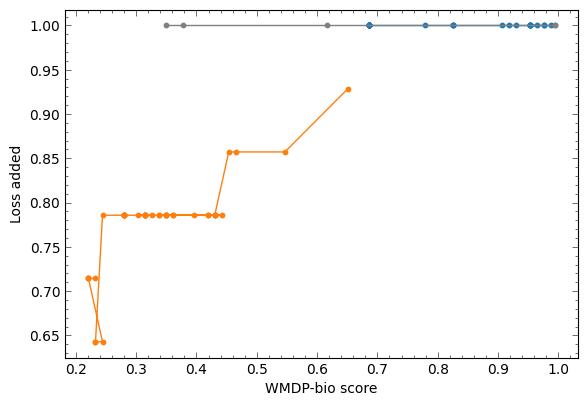

In [17]:
fig, ax = plt.subplots(figsize=(6, 4))


yaxis = "high_school_us_history"

with open("../eoin_notebooks/df_metrics_0_side_effect.pkl", "rb") as f:
    df = pickle.load(f)
    
ax.plot(df['wmdp-bio'].values, df[yaxis].values)
ax.scatter(df['wmdp-bio'].values, df[yaxis].values, marker='o', s=10)

with open("../eoin_notebooks/df_metrics_5_side_effect.pkl", "rb") as f:
    df = pickle.load(f)
    
ax.plot(df['wmdp-bio'].values, df[yaxis].values)
ax.scatter(df['wmdp-bio'].values, df[yaxis].values, marker='o', s=10)



# Plot RMU results

rmu_wmdp_bio_results = []
rmu_side_effect_results = []
rmu_loss_added_results = []

for model_name in gemma_2b_it_rmu_model_names:
    model_name = model_name.split('/')[-1]
    with open(f'../data/unlearn_results/gemma-2b-it/rmu/correct/{model_name}.pkl', 'rb') as f:
        results = pickle.load(f)
    rmu_wmdp_bio_results.append(results['wmdp-bio']['mean_correct'])
    rmu_side_effect_results.append(results[yaxis]['mean_correct'])
    rmu_loss_added_results.append(results['loss_added'])
    
# ax.plot(rmu_wmdp_bio_results, rmu_loss_added_results, color='grey')
# ax.scatter(rmu_wmdp_bio_results, rmu_loss_added_results, s=10, marker='o', color='grey')

ax.plot(rmu_wmdp_bio_results, rmu_side_effect_results, color='grey')
ax.scatter(rmu_wmdp_bio_results, rmu_side_effect_results, s=10, marker='o', color='grey')


ax.legend()


ax.set_xlabel("WMDP-bio score")
ax.set_ylabel("Loss added")


fig.subplots_adjust(right=0.98, top=0.98)
fig.savefig(fig_dir + "/multiple_features/prob_vs_multiplier3.png", dpi=400)
# plt.show()




In [15]:
df

,loss_added,wmdp-bio,high_school_us_history,college_computer_science,high_school_geography,human_aging,college_biology,wmdp-bio_prob,high_school_us_history_prob,college_computer_science_prob,high_school_geography_prob,human_aging_prob,college_biology_prob
0,-0.031077,0.651163,0.928571,0.75,1.000000,0.8750,1.000,0.964844,0.941406,0.961426,0.998047,0.971680,0.996094
1,-0.034684,0.546512,0.857143,0.75,0.933333,0.7500,0.875,0.902344,0.956543,0.917969,0.941406,0.971680,0.945312
2,-0.034004,0.465116,0.857143,0.75,0.866667,0.6875,0.750,0.933105,0.947754,0.965820,0.989746,0.911621,0.939453
3,-0.033031,0.453488,0.857143,0.75,0.866667,0.7500,0.750,0.925781,0.946289,0.965820,0.989746,0.874512,0.939453
4,-0.032873,0.430233,0.785714,0.75,0.800000,0.7500,0.750,0.943359,0.886719,0.965820,0.950195,0.877441,0.939453
5,-0.032995,0.430233,0.785714,0.75,0.800000,0.8125,0.750,0.942871,0.886719,0.965820,0.950195,0.875488,0.939453
6,-0.033091,0.430233,0.785714,0.75,0.800000,0.8125,0.750,0.942871,0.886719,0.965820,0.950195,0.875488,0.939453
7,-0.032596,0.418605,0.785714,0.75,0.800000,0.8125,0.750,0.945801,0.886230,0.964355,0.924805,0.875488,0.949219
8,-0.032342,0.418605,0.785714,0.75,0.800000,0.8125,0.750,0.945801,0.886230,0.964355,0.924805,0.875488,0.949219
9,-0.032318,0.360465,0.785714,0.75,0.800000,0.8125,0.625,0.921387,0.886230,0.964355,0.924805,0.886719,0.986328
